# Bitcoin Prediction using LSTM with Keras


In [100]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

## Data Exploration

In [101]:
data = pd.read_csv("data/bitcoin.csv")
data = data.sort_values('Date')
data.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
2000,2014-12-01,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1999,2014-12-02,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1998,2014-12-03,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1997,2014-12-04,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1996,2014-12-05,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


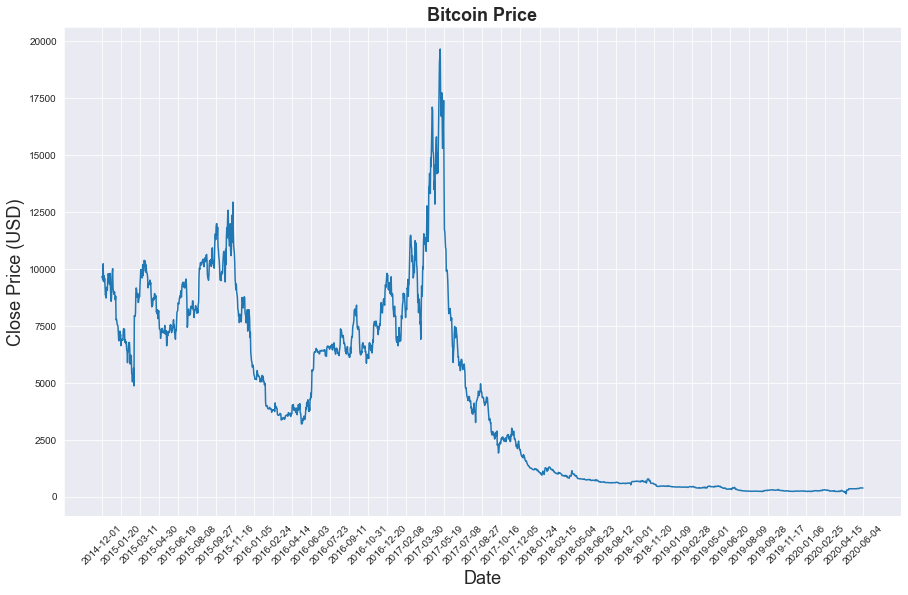

In [102]:
price = data[['Close']]

plt.figure(figsize = (15,9))
plt.plot(price)
plt.xticks(range(0, data.shape[0],50), data['Date'].loc[::50],rotation=45)
plt.title("Bitcoin Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [103]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 2000 to 0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2001 non-null   float64
dtypes: float64(1)
memory usage: 31.3 KB


## Data Preparation

### Normalization

In [104]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

norm_data = min_max_scaler.fit_transform(price.values)

### Data split

In [105]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

past_history = 5
future_target = 0
TRAIN_SPLIT = 1500


x_train, y_train = univariate_data(norm_data, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
x_val, y_val = univariate_data(norm_data, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

## Build the model

In [106]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

num_units = 4
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 5
num_epochs = 10

# Initialize the RNN
model = Sequential()

# Adding the input layer and the LSTM layer
model.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 1)))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = optimizer, loss = loss_function)

In [107]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [108]:
# Using the training set to train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = batch_size, epochs = num_epochs)

Train on 1495 samples, validate on 496 samples
Epoch 1/10
1495/1495 [==============================] - 1s 913us/step - loss: 0.0740 - val_loss: 0.0547
Epoch 2/10
1495/1495 [==============================] - 1s 612us/step - loss: 0.0239 - val_loss: 0.0438
Epoch 3/10
1495/1495 [==============================] - 1s 559us/step - loss: 0.0191 - val_loss: 0.0340
Epoch 4/10
1495/1495 [==============================] - 1s 600us/step - loss: 0.0141 - val_loss: 0.0236
Epoch 5/10
1495/1495 [==============================] - 1s 557us/step - loss: 0.0092 - val_loss: 0.0150
Epoch 6/10
1495/1495 [==============================] - 1s 583us/step - loss: 0.0050 - val_loss: 0.0052
Epoch 7/10
1495/1495 [==============================] - 1s 563us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/10
1495/1495 [==============================] - 1s 577us/step - loss: 8.9808e-04 - val_loss: 5.2216e-04
Epoch 9/10
1495/1495 [==============================] - 1s 560us/step - loss: 5.7070e-04 - val_loss: 4.7496e-04
E

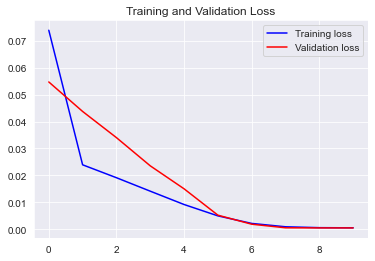

In [109]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Prediction
For each of the items we used for the validation, let's now predict them so we can compare how well we did.

[]

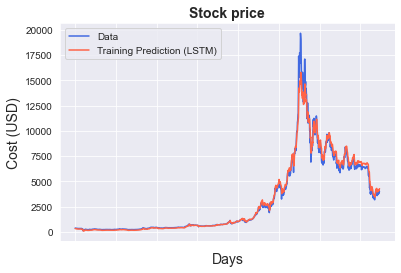

In [110]:
original = pd.DataFrame(min_max_scaler.inverse_transform(y_train))
predictions = pd.DataFrame(min_max_scaler.inverse_transform(model.predict(x_train)))

ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predictions.index, y = predictions[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)